In [1]:
from layer import *

from __future__ import division
import random
import math
import numpy as np
import pandas as pd
import time
from numpy.linalg import norm

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(load_iris().data)
y = np.vectorize(lambda x: 1 if(x>0) else 0)(load_iris().target).astype(np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=10, stratify=y)
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)
y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [2]:
input_size = X.shape[1]
computational_layer = 5
output_layer = 1
dimensions = calculate_dimensions(input_size, computational_layer, output_layer)

def position_check(new_position):
    new_position = np.vectorize(lambda z: Wildebeest.pmax if z > Wildebeest.pmax else float(z)) (new_position)
    new_position = np.vectorize(lambda z: Wildebeest.pmin if z < Wildebeest.pmin else float(z)) (new_position)
    return new_position

In [3]:
class Wildebeest:
    global dimensions
    global_best_position = np.random.random((dimensions,))
    global_best_cost, _ = forward_pass_weights_bin(global_best_position,X_train,y_train,input_size,computational_layer,output_layer)
    pmax = 10
    pmin = -10
    
    def __init__(self, dimensions):
        self.position = np.random.random((dimensions,))
        self.cost, _ = forward_pass_weights_bin(self.position,X_train,y_train,input_size,computational_layer,output_layer)
        self.dimensions = dimensions
        self.velocity = np.random.random((dimensions,))
        self.pmax = 10
        self.pmin = -10
        
        self.alpha_1 = 0.9 #Local movement
        self.beta_1 = 0.3  #Local movement
        self.alpha_2 = 0.2 #Global movement
        self.beta_2 = 0.8  #Global movement
        
        self.delta_w = 2 #Threshold for nearness
        self.delta_c = 2 #Threshold for avoiding crowds
        
        self.learning_rate = 0.2
        self.n_steps = 4
        self.n_e = 4


    def take_steps(self):
        steps = []

        for _ in range(self.n_steps):
            new_random_velocity = -1 + 2*np.random.random((self.dimensions,));
            new_random_position = position_check(self.position + random.random()*new_random_velocity/norm(new_random_velocity))
            new_cost, _ = forward_pass_weights_bin(new_random_position,X_train,y_train,input_size,computational_layer,output_layer)
            steps.append([new_random_position, new_cost])

        steps = sorted(steps, key = lambda x: x[1])

        return steps
    
    def update_position(self, new_position, new_cost):
        
        self.position = position_check(self.alpha_1 * new_position + self.beta_1 * (self.position - new_position))
        self.cost, _ = forward_pass_weights_bin(self.position,X_train,y_train,input_size,computational_layer,output_layer)
        
        if(self.cost < Wildebeest.global_best_cost):
            global_best_position = self.position
            global_best_cost = self.cost

    
    def herd_instinct(self, random_wildebeest):
    
        if(random_wildebeest.cost-1 < self.cost and random.random() < 0.3):
            self.position = position_check(self.alpha_2 * self.position + self.beta_2 * random_wildebeest.position)
            self.cost, _ = forward_pass_weights_bin(self.position,X_train,y_train,input_size,computational_layer,output_layer)
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost

    def feed_information(self, worst_position):
        
        if(norm(self.position-worst_position) < self.delta_w):
            new_random_velocity = -1 + 2*np.random.random((self.dimensions,));
            self.position = position_check(self.position + random.random()*10*(self.pmax-self.pmin)*new_random_velocity/norm(new_random_velocity))
            self.cost, _ = forward_pass_weights_bin(self.position,X_train,y_train,input_size,computational_layer,output_layer)
            
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost
                
        
        if(norm(Wildebeest.global_best_position - self.position) < self.delta_c and norm(Wildebeest.global_best_position - self.position) > 1):
            self.position = position_check(Wildebeest.global_best_position + 0.0001*np.random.random((self.dimensions,)))
            self.cost, _ = forward_pass_weights_bin(self.position,X_train,y_train,input_size,computational_layer,output_layer)
            
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost
        
        for _ in range(self.n_e):
            velocity = -1 + 2*np.random.random((self.dimensions,))
            position = position_check(Wildebeest.global_best_position + 0.1 * (velocity/norm(velocity)))
            cost, _ = forward_pass_weights_bin(position,X_train,y_train,input_size,computational_layer,output_layer)
            
            if(cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = position
                Wildebeest.global_best_cost = cost


In [4]:
n_iterations = 100
n_population = 80

agents = [Wildebeest(dimensions = dimensions) for x in range(n_population)]
temp = []
cost_list = []

In [5]:
start = time.time()
for _ in range(n_iterations):

    for agent in agents:
        steps = agent.take_steps()[0]
        agent.update_position(steps[0], steps[1])

    for agent in agents:
        h = random.randint(1,n_population)
        random_agent = agents[h-1]
        agent.herd_instinct(random_agent)

    for agent in agents:
        temp.append([agent.position,agent.cost])
    worst_position = sorted(temp, key = lambda x: x[1])[-1][0]

    for agent in agents:
        agent.feed_information(worst_position)

    cost_list.append(Wildebeest.global_best_cost)

end = time.time()
print(end-start)

cost, output = forward_pass_weights_bin(Wildebeest.global_best_position,X_train,y_train,input_size, computational_layer, output_layer)
print(cost)
print(reg_cost(y_train, output))
print(mae(y_train, output))

40.489774227142334
0.43989018519899165
8.857125000657918e-24
5.582198464393848e-13


In [6]:
cost, output = forward_pass_weights_bin(Wildebeest.global_best_position,X_test,y_test,input_size, computational_layer, output_layer)
print(cost)
print(reg_cost(y_test, output))
print(mae(y_test, output))


0.43989018519879713
6.302153381523014e-33
1.1935318574065094e-17


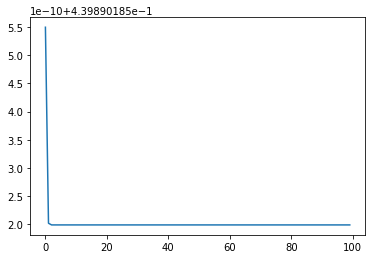

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(n_iterations), y = cost_list)